<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='40%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./331_Sentinel-3_SLSTR_NRT_FRP_Chernobyl_fires_case_study.ipynb"><< 331 - Case study - Sentinel-3 SLSTR NRT FRP - Chernobyl fires</a><span style="float:right;"><a href="./333_Sentinel-3_SLSTR_NRT_AOD_Californian_fires_case_study.ipynb">333 - Case study - Sentinel-3 SLSTR NRT AOD - Californian fires >></a></span>

<div class="alert alert-block alert-warning">
<b>30 - CASE STUDIES</b></div>

<div class="alert alert-block alert-warning">

<b>PREREQUISITES </b>

The following **20 - DATA DISCOVERY** module is a prerequisite:   
- [252 - Sentinel-3 SLSTR NRT - Fire Radiative Power - Load and browse](../20_data_discovery/252_Sentinel-3_SLSTR_NRT_FRP_load_browse.ipynb)

It is recommended to go through the module before you start with this module.
</div>

<hr>

# 3.3.2 Sentinel-3 Near Real Time SLSTR Fire Radiative Power (FRP)

###  Example Californian fires - September 2020

The [Copernicus Sentinel-3 (S3) Near Real Time (NRT) Fire Radiative Power (FRP)](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) product, implemented by EUMETSAT, detects and monitors the **immediate threats of any 'burning' events over an area size of 1 km<sup>2</sup>**. 

Commonly gathered under the term of hotspots, these are not only fires over continents, but also flames from persistent land and ocean gas flares, and active erupting volcanoes. 

It is applicable to **agricultural burning, wildfires, deforestation, tropical peatland fires, industrial gas flares, and volcanoes**, all emit radiative signatures with a high seasonal and geographical variability. The current version of the Near Real Time Sentinel-3 Fire Radiative Power product is considered as 'preliminary operational'. It is mainly applicable during nighttime

Get more product specifications [here](https://www.eumetsat.int/website/home/News/DAT_4962463.html).

The following workflow is based on an example of `Sentinel-3 Near Real Time SLSTR FRP` data on 12 September 2020 capturing the severe wildfires in California, US.

### Outline
* [1 - Load Sentinel-3 NRT SLSTR FRP data](#load_s3_frp)
* [2 - Load, mask and regrid FRP computed from MWIR channel (3.7 um)](#load_mwir)
* [3 - Load, mask and regrid FRP computed from SWIR channel (2.25 um)](#load_swir)
* [4 - Load, mask and regrid FRP computed from SWIR channel (2.25 um) with SAA filter applied](#load_swir_nosaa)

<hr>

#### Load required libraries

In [1]:
import xarray as xr

import numpy as np
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [8]:
%run ../functions.ipynb

<hr>

## <a id='load_s3_frp'></a>Load Sentinel-3 Near-Real-Time SLSTR FRP data

Sentinel-3 Near Real Time SLSTR FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `open_dataset()` function.


Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are three variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW] - to detect fires with temperatures less than 1000 Kelvin
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW] - to detect fires with temperatures above 1000 Kelvin
- `FLAG_SWIR_SAA` - Flag values to filter out South Atlantic ANomalies (SAA) & other transient / spurious events, only applicable to FRP SWIR

In [2]:
frp_dir = '../eodata/sentinel3/slstr/2020/09/12/'
frp_xr = xr.open_dataset(frp_dir+'FRP_in_California_202000912.nc')
frp_xr

<xarray.Dataset>
Dimensions:                 (columns: 1500, fires: 983, rows: 2000)
Dimensions without coordinates: columns, fires, rows
Data variables:
    i                       (fires) int16 ...
    j                       (fires) int32 ...
    time                    (fires) datetime64[ns] ...
    latitude                (fires) float64 ...
    longitude               (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    transmittance_MWIR      (fires) float64 ...
    FRP_SWIR                (fires) float64 ...
    FRP_uncertainty_SWIR    (fires) float64 ...
    FLAG_SWIR_SAA           (fires) int16 ...
    transmittance_SWIR      (fires) float64 ...
    confidence              (fires) float64 ...
    classification          (fires) uint8 ...
    S7_Fire_pixel_radiance  (fires) float32 ...
    F1_Fire_pixel_radiance  (fires) float32 ...
    used_channel            (fires) uint8 ...
    Radiance_window         (fires) float32 ...
    Glint_angle             (fires) float64 ...
    IFOV_area               (fires) float64 ...
    TCWV                    (fires) float64 ...
    n_window                (fires) int16 ...
    n_water                 (fires) int16 ...
    n_cloud                 (fires) int16 ...
    n_SWIR_fire             (fires) float32 ...
    flags                   (rows, columns) uint32 ...
Attributes:
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20200912T060733_20200912T061233_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 02.00
    history:                 
    references:             S3MPC ACR FRP 003 - i1r2 - SLSTR L2 Product Data ...
    contact:                ops@eumetsat.int
    creation_time:          2020-09-12T08:42:25Z
    resolution:             [ 1000 1000 ]
    absolute_orbit_number:  23806
    start_time:             2020-09-12T06:07:32.889933Z
    stop_time:              2020-09-12T06:12:32.876462Z
    track_offset:           998
    start_offset:           2960

### Load `latitude` and `longitude` information

You can already load the `latitude` and `longitude` information, which are two variables in the loaded `xarray.Dataset`. Latitude and longitude information will be required for the regridding process.

In [4]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lat_frp

<xarray.DataArray 'latitude' (fires: 983)>
array([34.20978 , 34.207463, 34.206402, ..., 44.773218, 44.780361, 44.815262])
Dimensions without coordinates: fires
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0

### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [5]:
sampling_lat_FRP_grid = 0.05        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.05        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots


lat_min               = 30.        # Minimum latitude for mapping plot [deg N]
lat_max               = 50.        # Maximum latitude for mapping plot [deg N]
lon_min               = -125.        # Minimum lonitude for mapping plot [deg E]
lon_max               = -110.        # Maximum lonitude for mapping plot [deg E]

Now, let us go through the three different variables (`MWIR`, `SWIR` and `SWIR with SAA filtered out`) and let us load, mask, regrid and visualize them.

## <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You see that in total 983 fire entries were detected.

In [6]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 983)>
array([29.001723,  3.319766,  6.212274, ...,  3.228371,  2.052163,  2.190705])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

The next step is to extract (mask) only the FRP pixels detected by the `MWIR` channel. Valid pixels are different to -1. You can use the function [generate_masked_array](../functions.ipynb#generate_masked_array) to extract the right pixels. There were 947 fire entries with a temperature less than 1000 Kelvin detected.

In [9]:
masked_frp_mwir = generate_masked_array(xarray=frp_mwir, 
                                        mask=frp_mwir, 
                                        threshold=-1.,
                                        operator='!=', drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 947)>
array([2.90017228e+01, 3.31976591e+00, 6.21227395e+00, 1.54620940e+01,
       4.68897270e+01, 1.12332114e+00, 6.18965174e+01, 6.19149670e+01,
       1.49150777e+01, 2.68553413e+01, 1.10069436e+02, 2.45775621e+01,
       2.61668130e+01, 4.33408987e+01, 1.64290944e+01, 1.83668273e+01,
       2.62899536e+01, 2.05406704e+01, 2.11985483e+01, 1.39026835e+01,
       9.83339434e+00, 8.96743356e-01, 3.24738038e+01, 8.82385523e+00,
       9.79953234e+00, 1.01516512e+01, 1.06332844e+01, 7.59713837e+00,
       4.82291892e+00, 4.24031284e+01, 1.59761809e+01, 8.05953998e+00,
       2.95407260e+01, 2.31222189e+01, 3.27043456e+01, 1.68782050e+01,
       8.78751404e+01, 8.78545978e+01, 1.13304826e+01, 2.08873465e+01,
       3.07980512e+01, 2.59300387e+01, 1.03644351e+01, 1.86258119e+01,
       1.27626475e+01, 2.50509373e+01, 4.19246990e+01, 7.57480551e+00,
       4.18505043e+00, 5.81507143e+01, 1.14371338e+01, 2.03450912e+01,
       3.70746321e+01, 1.78408309e+01, 1.60965106e+01, 8.59292190e+00,
       1.22158347e+01, 1.03185624e+01, 9.17456144e+00, 9.27152823e+00,
       3.49734224e+01, 3.49308318e+01, 5.29665226e+00, 1.66800539e+01,
       1.01586137e+01, 8.22362855e+00, 3.16841166e+01, 6.83258678e+00,
       8.42721879e+00, 1.61962517e+01, 8.20943020e+00, 2.28961160e+01,
       2.52468381e+01, 1.52548126e+01, 5.38491262e+00, 2.42656409e+01,
       3.16232026e+01, 4.84855103e+00, 7.31684297e+01, 5.22320158e+00,
...
       1.78856947e+00, 2.41569105e+00, 2.81981323e+00, 1.73451445e+00,
       1.18740627e+00, 1.80706389e+01, 2.86287477e+00, 2.69165373e+00,
       1.29910697e+01, 1.56731741e+01, 3.69249921e+00, 4.31241887e+00,
       1.98103432e+00, 2.12256215e+00, 2.32410247e+00, 2.19475492e+01,
       3.61717005e+00, 3.61494431e+00, 3.19642464e+00, 3.61449539e+00,
       4.91066825e+00, 1.03807410e+01, 2.10834044e+00, 2.09997201e+01,
       3.49179818e+00, 4.17740751e+00, 4.16992738e+00, 2.33489186e+00,
       3.55750619e+00, 6.87252687e+00, 2.97174139e+00, 2.79907336e+00,
       4.19815756e+00, 5.93116206e+00, 4.76309675e+00, 4.10701547e+00,
       4.59747954e+00, 3.26218998e+00, 6.89366635e+00, 8.99779051e+00,
       7.42398859e+00, 1.95245927e+01, 6.84967037e+00, 1.81849789e+00,
       1.31833361e+00, 4.45365592e+00, 3.52931715e+00, 1.25635260e+00,
       4.04953166e+00, 1.98248985e+00, 1.98208059e+00, 1.02024401e+00,
       1.52514242e+00, 1.61625397e+00, 2.86512589e+00, 8.94506595e-01,
       1.18528220e+00, 1.02283092e+00, 2.95828143e+00, 4.66141381e+00,
       2.31194599e+00, 3.43929993e+00, 2.37473881e+00, 8.95867030e-01,
       8.85686092e-01, 1.09169750e+00, 3.18484807e+00, 8.87985420e-01,
       1.56605980e+00, 1.22353878e+00, 1.16370672e+00, 1.15645119e+00,
       8.84748225e-01, 1.15574361e+00, 1.16390325e+00, 1.22427473e+00,
       3.22837072e+00, 2.05216264e+00, 2.19070534e+00])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

Let us store the number of hotspots / fires in total and per category as variables.

In [11]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(983, 947)

### Generate a gridded FRP array

In a next step, let us compute the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can use the function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) for the gridding process.

In [12]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_mwir,
                                                       parameter='mwir',
                                                       lat_min=lat_min, 
                                                       lat_max=lat_max, 
                                                       lon_min=lon_min, 
                                                       lon_max=lon_max, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_MWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)

FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[30.025, 30.025, 30.025, ..., 30.025, 30.025, 30.025],
        [30.075, 30.075, 30.075, ..., 30.075, 30.075, 30.075],
        [30.125, 30.125, 30.125, ..., 30.125, 30.125, 30.125],
        ...,
        [49.925, 49.925, 49.925, ..., 49.925, 49.925, 49.925],
        [49.975, 49.975, 49.975, ..., 49.975, 49.975, 49.975],
        [50.025, 50.025, 50.025, ..., 50.025, 50.025, 50.025]],
       dtype=float32),
 array([[-124.975, -124.925, -124.875, ..., -110.075, -110.025, -109.975],
        [-124.975, -124.925, -124.875, ..., -110.075, -110.025, -109.975],
        [-124.975, -

Mask out the invalid pixels for plotting. You can use numpy's function `np.ma.masked_array()` for this.

In [13]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Calculate some statistics, e.g. mean, std, min and max, and add them to a string that can be integrated in the final plot.

In [14]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



### Visualize the masked data array with matplotlib's `pcolormesh()` function

You can use the function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) to visualize the Fire Radiative Power computed from the MWIR channels. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

The function takes the following keyword arguments:
* `data`: DataArray with fire hotspots
* `lat`: Latitude information
* `lon`: Longitude information
* `unit`: Unit of the data
* `longname`: Long name of the data
* `textstr_1`: Text that contains the total number of 1km hot-spots
* `textstr_2`: Text that contains summary statistics of the data
* `vmax`: Maximum value to be visualized

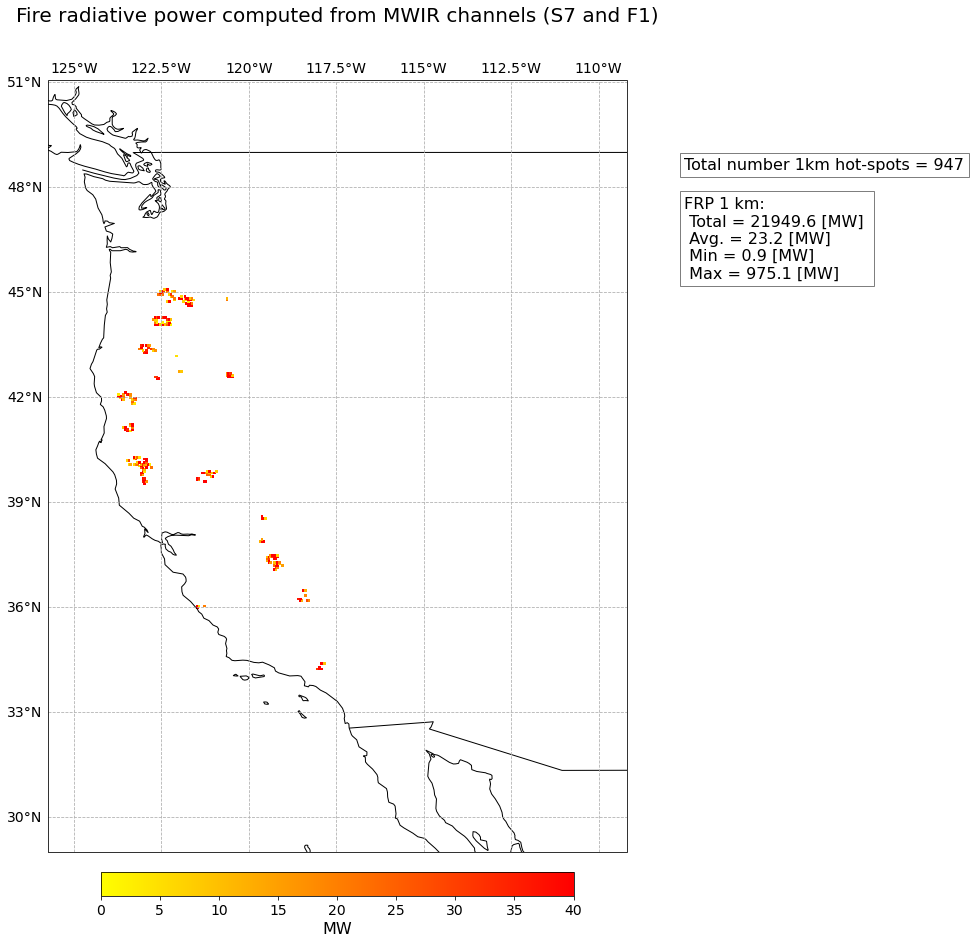

In [15]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_mwir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name, 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

Let us now repeat the processing steps above and let us process and visualize the `Fire Radiative Power computed from the SWIR channel`.

## <a id='load_swir'></a>Load, mask and regrid `FRP computed from SWIR channel (2.25 um)`

Load the `FRP_SWIR` data variable from the loaded `netCDF` file.

In [16]:
frp_swir = frp_xr['FRP_SWIR']
frp_swir

<xarray.DataArray 'FRP_SWIR' (fires: 983)>
array([-1., -1., -1., ..., -1., -1., -1.])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

Filter only the pixels that showed a FRP signal from the SWIR channel and filter all pixels equals -1 out. Use the function [generate_masked_array](../functions.ipynb#generate_masked_array) for the filtering. You see that 312 signals were detected by the SWIR channel, meaning these fires are more severe with having a temperature higher than 1000 Kelvin.

In [18]:
masked_frp_swir = generate_masked_array(xarray=frp_swir, 
                                        mask=frp_swir, 
                                        threshold=-1., 
                                        operator='!=', 
                                        drop=True)
masked_frp_swir

<xarray.DataArray 'FRP_SWIR' (fires: 312)>
array([  6.15590971,   7.20202588,   6.80617567,   6.67272458,
         6.73184035, 116.83042605,  32.45694424,  16.8775531 ,
         6.36111283,  38.66680812,  17.40182199,   6.05835935,
        42.90547084,  40.72464734,  76.02138211,  15.41872409,
        10.78821363,  22.2563639 ,  28.80817864,  19.16703646,
        11.16097129,  13.49226123,  15.32447147,  24.82093983,
        12.2157895 ,  10.80247992,  10.35865071,  22.40554178,
         5.90788609,  23.79037487,  16.58696835,  75.53350287,
        33.45986333,   5.84170264,  39.98125941,  24.60839405,
        32.57828595,   5.78517452,   8.16769865,   9.45206931,
        49.94922968,   7.36113089,  22.41672547,   5.05971342,
         9.29801518,   5.22922096,  46.99049213,  11.44831326,
         7.70183562,  22.46592957,  74.8891515 ,  85.85090912,
        20.40923924,   4.83502596,  11.46239065,  16.70624775,
         8.98967755,   3.6249552 ,   5.07039278,  19.08895761,
        26.98218327,   6.71455563,  44.36819772,  11.20831601,
         9.3422613 ,   9.60603661,   3.34479425,   6.09422394,
        12.02351569,  24.19099404,   6.65241829,  36.32524736,
        17.64803292,   3.78631326,  17.1810978 ,   3.43205982,
         9.58476558,   7.18628696,   6.31543295,  18.25259745,
...
         3.67872833,   3.58771915,  16.3590956 ,  16.09014939,
         3.65876966,   7.26942095,   8.46600986,   6.36045485,
        38.20596795,  14.70096368,   3.86423357,   4.01533804,
         3.83687615,   3.70370951,  13.58268577,  61.26394162,
        65.32863826,   5.41051383,   6.34178467,   3.89982092,
        57.96029559,  51.66573697,   9.23763265,  19.58765369,
         4.15472161,   8.13982698,  43.95586964,  15.33420623,
         4.56640601,  26.62618675, 472.59474972, 563.87638317,
        13.00371736,   6.82160379, 304.74847238,  51.53590038,
        60.36190011,  58.21039595, 138.33318025,   3.2588495 ,
        11.93264227, 108.03363623,   6.22844184,  29.68088719,
       173.48770223,  42.55707677, 108.77094822, 154.99178661,
        17.26996745,  10.350814  ,  34.84169226,  12.07300881,
         4.36297522,   8.21168335,   6.17115295,   4.64625562,
        28.71831282,   7.537333  ,  50.04099623,  23.60921244,
        12.57938995,  27.63775253,   7.26695183,   3.90628667,
         4.17922235,   9.16423861,   7.55037094,   3.34996978,
         8.76809894,   6.11951863,   3.2302647 , 195.78118725,
         3.30800811,   3.66112207,   6.55770175,   8.82837865,
         5.35799958,   4.01636931,   3.91090109,   5.62221336])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

Store the number of total fires and per category as variables.

In [19]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR          = len(masked_frp_swir.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR

(983, 312)

Apply the gridding function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) and grid the `FRP computed from the SWIR channel`.

In [20]:
FRP_SWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_swir, 
                                                       parameter='swir', 
                                                       lat_min=lat_min, 
                                                       lat_max=lat_max, 
                                                       lon_min=lon_min, 
                                                       lon_max=lon_max, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_SWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp,)

FRP_SWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[30.025, 30.025, 30.025, ..., 30.025, 30.025, 30.025],
        [30.075, 30.075, 30.075, ..., 30.075, 30.075, 30.075],
        [30.125, 30.125, 30.125, ..., 30.125, 30.125, 30.125],
        ...,
        [49.925, 49.925, 49.925, ..., 49.925, 49.925, 49.925],
        [49.975, 49.975, 49.975, ..., 49.975, 49.975, 49.975],
        [50.025, 50.025, 50.025, ..., 50.025, 50.025, 50.025]],
       dtype=float32),
 array([[-124.975, -124.925, -124.875, ..., -110.075, -110.025, -109.975],
        [-124.975, -124.925, -124.875, ..., -110.075, -110.025, -109.975],
        [-124.975, -

Mask out all invalid pixels for plotting.

In [21]:
mask_valid = np.where(FRP_SWIR_grid[:,:] != -9999., False, True)
D_swir = np.ma.masked_array(FRP_SWIR_grid[:,:], mask=mask_valid)

Calculate some statistics, e.g. mean, std, min and max, and add them to a string that can be integrated in the final plot.

In [22]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR)


FRP_sum      = np.sum(masked_frp_swir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



Apply the plotting function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) and take some attributes from the attributes stored in the original data file, e.g. `long_name` or `units`.

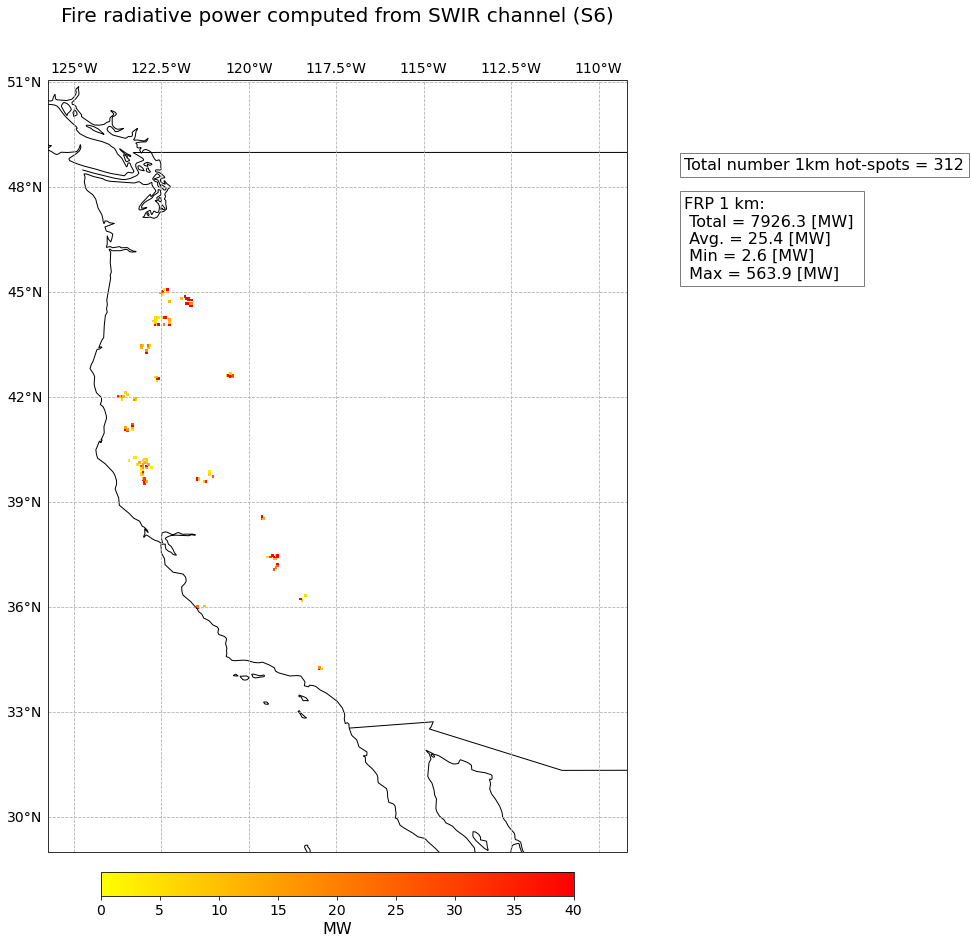

In [23]:
long_name = frp_swir.long_name
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_swir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name, 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<br>

Let us repeat the same processing steps for the `FRP computed from SWIR channel`, but with the SAA filter applied.

## <a id='load_swir_nosaa'></a> Load, mask and regrid `FRP computed from SWIR channel (2.25 um) with SAA filter applied`

Load the flag for the `South Atlantic Anomaly (SAA)` with the data variable name `FLAG_SWIR_SAA`. 

In [24]:
FLAG_FRP_SWIR_SAA_nc = frp_xr['FLAG_SWIR_SAA']
FLAG_FRP_SWIR_SAA_nc

<xarray.DataArray 'FLAG_SWIR_SAA' (fires: 983)>
array([-1, -1, -1, ..., -1, -1, -1], dtype=int16)
Dimensions without coordinates: fires
Attributes:
    long_name:      Flag South Atlantic Anomaly (SAA) suspected from SWIR cha...
    flag_values:    [-1  0  1  2  3  4]
    flag_meanings:  NA Unlikely Possible Spare Spare Spare

Filter out only the fire events detected by the SWIR channel including the South Atlantic Anomaly (SAA) filter. For this, you first have to create a mask including the signals detected by the SWIR channel (`frp_swir` object not equal to -1) and all SAA flags unequal to 0 (FLAG_FRP_SWIR_SAA_nc equals to 0) filtered out.

In a further step, you can use the function [generate_masked_array](../functions.ipynb#generate_masked_array) to apply the mask from the first step to the `frp_swir` `xarray.DataArray`.
You see that only 201 fire events fall under this category.

In [26]:
mask_frp_swir_nosaa = xr.where((frp_swir!=-1.) & (FLAG_FRP_SWIR_SAA_nc==0), 1, 0)
mask_frp_swir_nosaa

masked_frp_swir_nosaa = generate_masked_array(xarray=frp_swir,
                                               mask=mask_frp_swir_nosaa,
                                               threshold=1,
                                               operator='=',
                                               drop=True)
masked_frp_swir_nosaa

<xarray.DataArray (fires: 201)>
array([  6.73184035, 116.83042605,  32.45694424,  16.8775531 ,
        38.66680812,  17.40182199,   6.05835935,  42.90547084,
        40.72464734,  76.02138211,  15.41872409,  10.78821363,
        22.2563639 ,  28.80817864,  11.16097129,  13.49226123,
        15.32447147,  24.82093983,  23.79037487,  16.58696835,
        75.53350287,  33.45986333,  39.98125941,  24.60839405,
        32.57828595,   5.78517452,   8.16769865,   9.45206931,
        49.94922968,   7.36113089,  22.41672547,  46.99049213,
        11.44831326,  22.46592957,  74.8891515 ,  85.85090912,
        20.40923924,  11.46239065,  16.70624775,   8.98967755,
         5.07039278,  19.08895761,  26.98218327,   6.71455563,
        44.36819772,   3.34479425,   6.09422394,  12.02351569,
        24.19099404,   6.65241829,  36.32524736,  17.64803292,
        17.1810978 ,   3.43205982,   9.58476558,   7.18628696,
         6.31543295,   3.97575959,   6.1899337 ,  32.37610873,
         6.69481108,   5.61642913,   4.90796165,  44.19950121,
         4.73139931,   7.09666527,   8.77072375,  19.22467932,
        18.08664591,   3.96660022,   4.80192374,   4.02535646,
        11.25540544,  16.71592725,   6.16918245,  11.49381889,
         9.40831319,   2.87100307,  11.70790413,   6.30426873,
...
        24.12987155,   5.08491212,  87.71507282,  34.52722011,
        33.41292611,  32.0305966 , 102.80297761,   9.78098681,
         6.83501475,   8.23185475,  16.63250376,   5.39711822,
        32.59815683,  30.87579138,  10.40514318,  36.25928062,
        39.39960613,  10.34940556,  46.28211413,  39.88435617,
         6.15932721,   5.64955031,  23.48980998,   8.97605228,
        47.60779846,  20.47192908,   9.23719568,   4.43760721,
        31.25119127, 121.50429426,   9.05090059,  16.3590956 ,
        16.09014939,  38.20596795,  14.70096368,  61.26394162,
        65.32863826,  57.96029559,  51.66573697,   9.23763265,
        19.58765369,   4.15472161,   8.13982698,  43.95586964,
        15.33420623,  26.62618675, 472.59474972, 563.87638317,
         6.82160379, 304.74847238,  51.53590038,  60.36190011,
        58.21039595, 138.33318025,  11.93264227, 108.03363623,
         6.22844184,  29.68088719, 173.48770223,  42.55707677,
       108.77094822, 154.99178661,  34.84169226,  12.07300881,
        28.71831282,   7.537333  ,  23.60921244,  27.63775253,
         7.26695183,   9.16423861,   8.76809894,   6.11951863,
       195.78118725,   3.66112207,   8.82837865,   5.35799958,
         4.01636931])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

Let us store the total number of fires and of the category `FRP SWIR` with SAA filter applied as variables.

In [27]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR_NoSAA    = len(masked_frp_swir_nosaa.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR_NoSAA

(983, 201)

Apply the gridding function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) to grid the filtered `FRP SWIR` data. Additionally to the mandatory kwargs, you have to specify a `flag` kwarg, where you provide the function the `xarray.DataArray` loaded at the beginning, `FLAG_FRP_SWIR_SAA_nc`.

In [28]:
FRP_SWIR_NoSAA_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_swir,
                                                             parameter='swir_nosaa', 
                                                             lat_min=lat_min, 
                                                             lat_max=lat_max, 
                                                             lon_min=lon_min, 
                                                             lon_max=lon_max, 
                                                             sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                             sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                             n_fire=n_fire_SWIR_NoSAA, 
                                                             lat_frp=lat_frp,
                                                             lon_frp=lon_frp,
                                                             flag=FLAG_FRP_SWIR_SAA_nc)

FRP_SWIR_NoSAA_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[30.025, 30.025, 30.025, ..., 30.025, 30.025, 30.025],
        [30.075, 30.075, 30.075, ..., 30.075, 30.075, 30.075],
        [30.125, 30.125, 30.125, ..., 30.125, 30.125, 30.125],
        ...,
        [49.925, 49.925, 49.925, ..., 49.925, 49.925, 49.925],
        [49.975, 49.975, 49.975, ..., 49.975, 49.975, 49.975],
        [50.025, 50.025, 50.025, ..., 50.025, 50.025, 50.025]],
       dtype=float32),
 array([[-124.975, -124.925, -124.875, ..., -110.075, -110.025, -109.975],
        [-124.975, -124.925, -124.875, ..., -110.075, -110.025, -109.975],
        [-124.975, -

Mask out the invalid pixels for plotting.

In [29]:
mask_valid = np.where(FRP_SWIR_NoSAA_grid[:,:] != -9999., False, True)
D_swir_NoSAA = np.ma.masked_array(FRP_SWIR_NoSAA_grid[:,:], mask=mask_valid)

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [30]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR_NoSAA)


FRP_sum      = np.sum(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir_nosaa.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'


Apply the function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) to visualize the data and make use of the data files attributes, e.g. `long_name` or `units`.

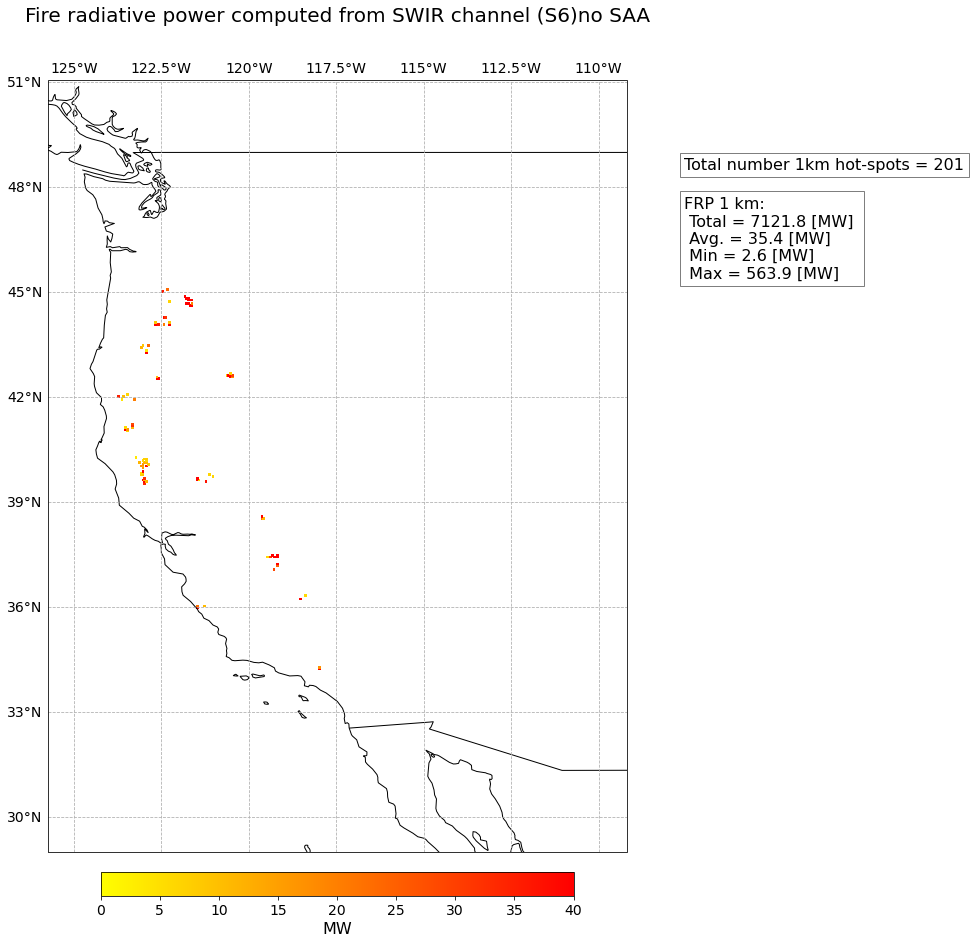

In [31]:
long_name = frp_swir.long_name
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_swir_NoSAA[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name + 'no SAA', 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./331_Sentinel-3_SLSTR_NRT_FRP_Chernobyl_fires_case_study.ipynb"><< 331 - Case study - Sentinel-3 SLSTR NRT FRP - Chernobyl fires</a><span style="float:right;"><a href="./333_Sentinel-3_SLSTR_NRT_AOD_Californian_fires_case_study.ipynb">333 - Case study - Sentinel-3 SLSTR NRT AOD - Californian fires >></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>